In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-d9gutvuc
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-d9gutvuc
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 0c136f7dab5b56e3feb411164264602db609f1f5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 

In [2]:
import os
import math
import time
import timm
import torch
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from pathlib import Path
input_path = Path('/kaggle/input')
for directory in input_path.rglob('*'):
    if directory.is_dir():
        print(directory)

/kaggle/input/Data
/kaggle/input/Data/valid
/kaggle/input/Data/test
/kaggle/input/Data/train
/kaggle/input/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
/kaggle/input/Data/valid/normal
/kaggle/input/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/kaggle/input/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/kaggle/input/Data/test/squamous.cell.carcinoma
/kaggle/input/Data/test/normal
/kaggle/input/Data/test/adenocarcinoma
/kaggle/input/Data/test/large.cell.carcinoma
/kaggle/input/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
/kaggle/input/Data/train/normal
/kaggle/input/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/kaggle/input/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [ ]:
data_dir = '/kaggle/input/Data'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [6]:
model = timm.create_model('pit_ti_224', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, 4)
model.to(device)

summary(model, (3, 224, 224))

model.safetensors:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 4]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [7]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 35

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_loss = total_loss / len(train_loader)
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time

    average_loss = total_loss / len(val_loader)
    
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/35]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Metrics - loss: 0.9175, accuracy: 0.6166, precision: 0.6135, recall: 0.6166, f1_score: 0.6082, specificity: 0.6718, sensitivity: 0.7464, mcc: 0.4801, auc: 0.8067


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Metrics - loss: 0.9937, accuracy: 0.6111, precision: 0.7110, recall: 0.6111, f1_score: 0.5827, specificity: 0.6957, sensitivity: 0.7347, mcc: 0.4769, auc: 0.7860


Training Model - Epoch [2/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.6133, accuracy: 0.7618, precision: 0.7576, recall: 0.7618, f1_score: 0.7587, specificity: 0.8000, sensitivity: 0.8732, mcc: 0.6787, auc: 0.8948


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Metrics - loss: 0.8602, accuracy: 0.6806, precision: 0.7814, recall: 0.6806, f1_score: 0.6675, specificity: 0.7391, sensitivity: 0.7959, mcc: 0.6002, auc: 0.8969


Training Model - Epoch [3/35]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Metrics - loss: 0.2584, accuracy: 0.9103, precision: 0.9103, recall: 0.9103, f1_score: 0.9103, specificity: 0.9077, sensitivity: 0.9569, mcc: 0.8790, auc: 0.9757


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Metrics - loss: 1.3077, accuracy: 0.6389, precision: 0.7709, recall: 0.6389, f1_score: 0.5884, specificity: 0.9565, sensitivity: 0.6122, mcc: 0.5566, auc: 0.9039


Training Model - Epoch [4/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.1397, accuracy: 0.9494, precision: 0.9498, recall: 0.9494, f1_score: 0.9493, specificity: 0.9487, sensitivity: 0.9593, mcc: 0.9318, auc: 0.9914


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Metrics - loss: 0.9686, accuracy: 0.6944, precision: 0.8576, recall: 0.6944, f1_score: 0.7153, specificity: 0.5217, sensitivity: 1.0000, mcc: 0.6503, auc: 0.9257


Training Model - Epoch [5/35]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Metrics - loss: 0.0943, accuracy: 0.9674, precision: 0.9675, recall: 0.9674, f1_score: 0.9673, specificity: 0.9692, sensitivity: 0.9809, mcc: 0.9560, auc: 0.9949


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Metrics - loss: 0.6224, accuracy: 0.8333, precision: 0.8764, recall: 0.8333, f1_score: 0.8343, specificity: 0.9130, sensitivity: 0.9184, mcc: 0.7880, auc: 0.9536


Training Model - Epoch [6/35]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Metrics - loss: 0.0763, accuracy: 0.9674, precision: 0.9672, recall: 0.9674, f1_score: 0.9672, specificity: 0.9590, sensitivity: 0.9737, mcc: 0.9560, auc: 0.9968


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Metrics - loss: 0.5728, accuracy: 0.8472, precision: 0.8588, recall: 0.8472, f1_score: 0.8489, specificity: 0.8696, sensitivity: 0.9388, mcc: 0.7942, auc: 0.9517


Training Model - Epoch [7/35]: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Metrics - loss: 0.0675, accuracy: 0.9772, precision: 0.9774, recall: 0.9772, f1_score: 0.9772, specificity: 0.9795, sensitivity: 0.9833, mcc: 0.9693, auc: 0.9970


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Metrics - loss: 0.6352, accuracy: 0.8333, precision: 0.8718, recall: 0.8333, f1_score: 0.8407, specificity: 0.8261, sensitivity: 0.9796, mcc: 0.7843, auc: 0.9599


Training Model - Epoch [8/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0124, accuracy: 0.9951, precision: 0.9951, recall: 0.9951, f1_score: 0.9951, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9934, auc: 0.9996


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Metrics - loss: 0.6078, accuracy: 0.8472, precision: 0.8928, recall: 0.8472, f1_score: 0.8535, specificity: 0.8696, sensitivity: 0.9592, mcc: 0.8066, auc: 0.9680


Training Model - Epoch [9/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0049, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 0.9999


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Metrics - loss: 0.5860, accuracy: 0.8611, precision: 0.8779, recall: 0.8611, f1_score: 0.8624, specificity: 0.9130, sensitivity: 0.9184, mcc: 0.8154, auc: 0.9703


Training Model - Epoch [10/35]: 100%|██████████| 39/39 [00:38<00:00,  1.00it/s]


Metrics - loss: 0.0040, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 0.9999


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Metrics - loss: 0.5863, accuracy: 0.8750, precision: 0.8965, recall: 0.8750, f1_score: 0.8766, specificity: 0.9130, sensitivity: 0.9592, mcc: 0.8368, auc: 0.9748


Training Model - Epoch [11/35]: 100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Metrics - loss: 0.0032, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Metrics - loss: 0.5783, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9751


Training Model - Epoch [12/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0052, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Metrics - loss: 0.6062, accuracy: 0.8750, precision: 0.8965, recall: 0.8750, f1_score: 0.8766, specificity: 0.9130, sensitivity: 0.9592, mcc: 0.8368, auc: 0.9754


Training Model - Epoch [13/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0047, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Metrics - loss: 0.5800, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9747


Training Model - Epoch [14/35]: 100%|██████████| 39/39 [00:46<00:00,  1.18s/it]


Metrics - loss: 0.0054, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Metrics - loss: 0.5799, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9753


Training Model - Epoch [15/35]: 100%|██████████| 39/39 [00:40<00:00,  1.04s/it]


Metrics - loss: 0.0038, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Metrics - loss: 0.5857, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9750


Training Model - Epoch [16/35]: 100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Metrics - loss: 0.0038, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Metrics - loss: 0.5976, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9759


Training Model - Epoch [17/35]: 100%|██████████| 39/39 [00:40<00:00,  1.04s/it]


Metrics - loss: 0.0031, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Metrics - loss: 0.5922, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9755


Training Model - Epoch [18/35]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it]


Metrics - loss: 0.0039, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Metrics - loss: 0.5976, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9761


Training Model - Epoch [19/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0041, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Metrics - loss: 0.5957, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9760


Training Model - Epoch [20/35]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it]


Metrics - loss: 0.0028, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Metrics - loss: 0.5903, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9762


Training Model - Epoch [21/35]: 100%|██████████| 39/39 [00:38<00:00,  1.02it/s]


Metrics - loss: 0.0026, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Metrics - loss: 0.5999, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9769


Training Model - Epoch [22/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0035, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Metrics - loss: 0.5937, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9764


Training Model - Epoch [23/35]: 100%|██████████| 39/39 [00:38<00:00,  1.02it/s]


Metrics - loss: 0.0038, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Metrics - loss: 0.6113, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9776


Training Model - Epoch [24/35]: 100%|██████████| 39/39 [00:38<00:00,  1.02it/s]


Metrics - loss: 0.0080, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Metrics - loss: 0.5993, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9775


Training Model - Epoch [25/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0073, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Metrics - loss: 0.6199, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9783


Training Model - Epoch [26/35]: 100%|██████████| 39/39 [00:38<00:00,  1.02it/s]


Metrics - loss: 0.0049, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Metrics - loss: 0.5868, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9763


Training Model - Epoch [27/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0030, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Metrics - loss: 0.5982, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9773


Training Model - Epoch [28/35]: 100%|██████████| 39/39 [00:40<00:00,  1.04s/it]


Metrics - loss: 0.0036, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Metrics - loss: 0.6020, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9778


Training Model - Epoch [29/35]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it]


Metrics - loss: 0.0030, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Metrics - loss: 0.6036, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9773


Training Model - Epoch [30/35]: 100%|██████████| 39/39 [00:38<00:00,  1.00it/s]


Metrics - loss: 0.0031, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Metrics - loss: 0.6132, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9776


Training Model - Epoch [31/35]: 100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Metrics - loss: 0.0032, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Metrics - loss: 0.6104, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9778


Training Model - Epoch [32/35]: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it]


Metrics - loss: 0.0032, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Metrics - loss: 0.6109, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9778


Training Model - Epoch [33/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0031, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Metrics - loss: 0.6173, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9781


Training Model - Epoch [34/35]: 100%|██████████| 39/39 [00:38<00:00,  1.01it/s]


Metrics - loss: 0.0032, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9956, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Metrics - loss: 0.6234, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9776


Training Model - Epoch [35/35]: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Metrics - loss: 0.0037, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9978, auc: 1.0000


Validating Model: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

Metrics - loss: 0.6284, accuracy: 0.8750, precision: 0.8918, recall: 0.8750, f1_score: 0.8753, specificity: 0.9130, sensitivity: 0.9388, mcc: 0.8354, auc: 0.9780
Total Training Time: 0:23:02.073170
Total Validation Time: 0:01:18.751431
Average Training Time per Epoch: 0:00:39.487805
Average Validation Time per Epoch: 0:00:02.250041


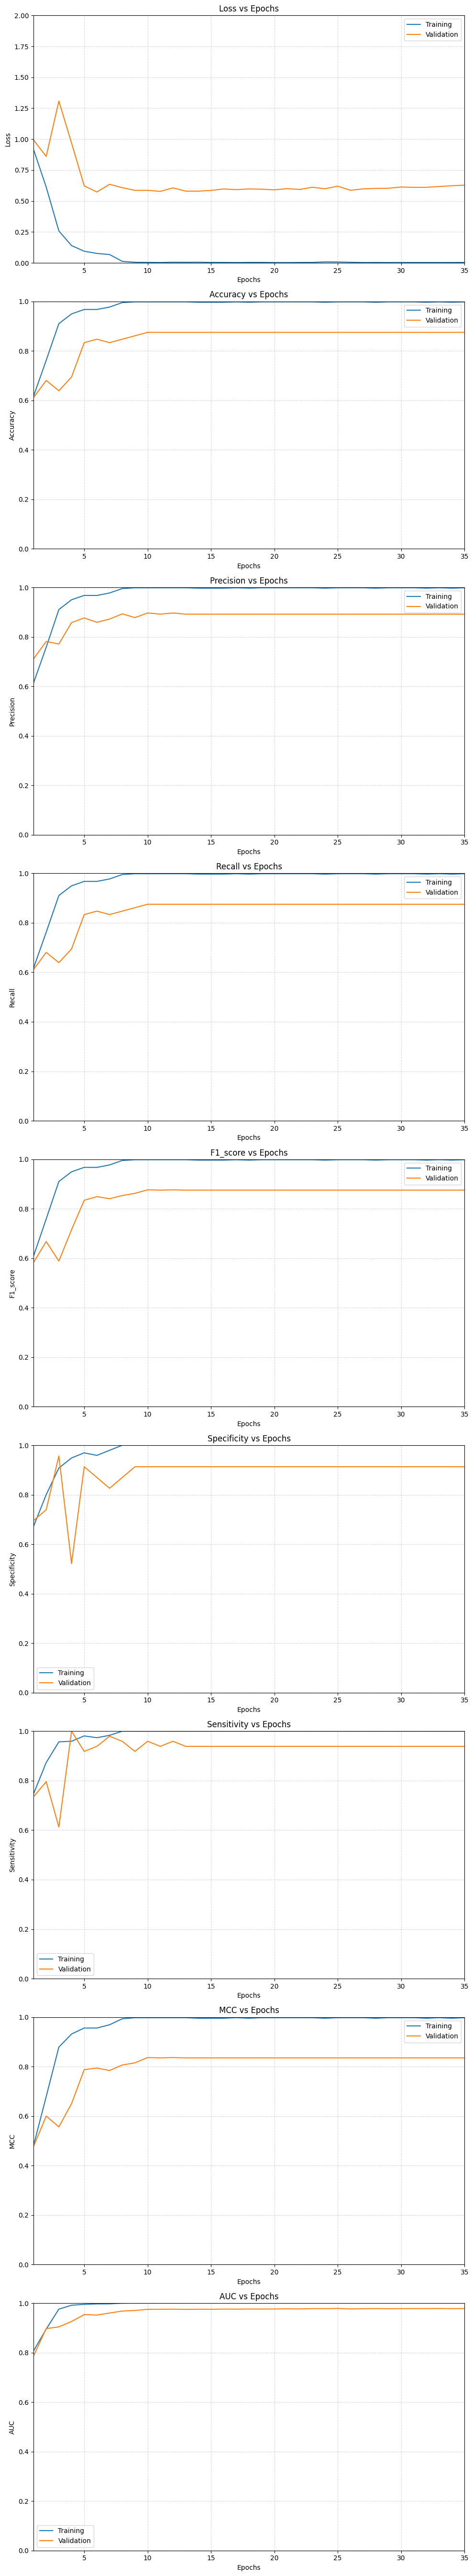

In [10]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [11]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]

Metrics - loss: 0.5170, accuracy: 0.8476, precision: 0.8585, recall: 0.8476, f1_score: 0.8480, specificity: 0.8167, sensitivity: 0.9077, mcc: 0.7933, auc: 0.9687


In [12]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=train_dataset.classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.8448    0.8167    0.8305       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.7000    0.9608    0.8099        51
                                          normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.8816    0.7444    0.8072        90

                                        accuracy                         0.8476       315
                                       macro avg     0.8566    0.8758    0.8596       315
                                    weighted avg     0.8585    0.8476    0.8480       315

There were 48 errors in 315 tests for an accuracy of  84.76


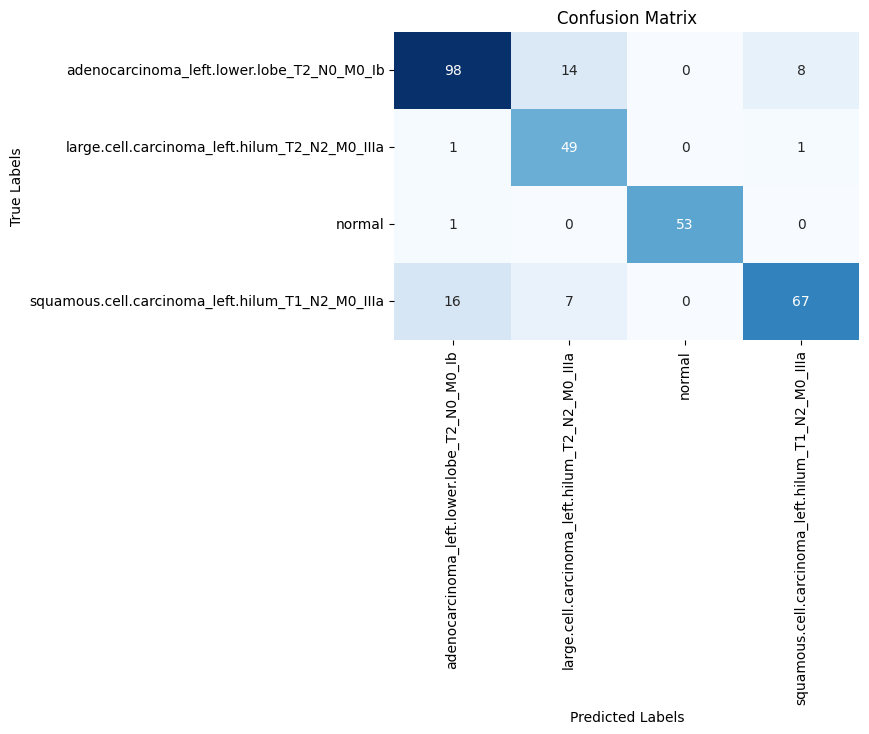

In [13]:
confusion_matrix = torch.zeros(4, 4)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()